In [1]:
import numpy as np
from scipy.special import k0, k1, factorial, i0, i1
from scipy.optimize import newton

import matplotlib.pyplot as plt

In [2]:
def stehfest_coef(M):
    """Compute M number of Stehfest coefficients.
    Algorithm from Bakker & Post (2022).

    Args:
        M (int): number of Stehfest coefficients to compute

    Returns:
        numpy 1D array: numpy 1D array with M floats containing the Stehfest coefficients
    """
    assert M % 2 == 0, "M must be even"
    M2 = int(M / 2)
    V = np.zeros(M)
    for k in range(1, M + 1):
        z = np.zeros(min(k, M2) + 1)
        for j in range(int((k + 1) / 2), min(k, M2) + 1):
            z[j] = (
                j**M2
                * factorial(2 * j)
                / (
                    factorial(M2 - j)
                    * factorial(j)
                    * factorial(j - 1)
                    * factorial(k - j)
                    * factorial(2 * j - k)
                )
            )
        V[k - 1] = (-1) ** (k + M2) * np.sum(z)
    return V

In [3]:
def ernst_tr(r, t, T, S, Q, c, N, return_R=False):
    """Compute transient hydraulic head using the transient Ernst equation for radial flow to a well, based
       on Louwyck et al., 2022.
       Leakage is incorporated coming from an overlying dense network of ditches which may become dry
       near the well, at distances closer than R. R is found by using a non-linear root finding algorithm at every time t.
       A constant saturated thickness is assumed.
       The transient Ernst equation is solved using a Laplace transform; inversion is perfomed using the Stehfest algorithm
       with 12 terms.

    Args:
        r (float or numpy 1D array): radial distance(s) from the well to compute the head at [L]
        r (float or numpy 1D array): time(s) since start of pumping to compute the head [T]
        T (float): aquifer transmissivity [L**2/T]
        S (float): aquifer storage coefficient [-].
        Q (float): well pumping rate (positive for extraction) [L**3/T]
        c (float): hydraulic resistance of the leaky layer [T]
        N (float): areal recharge rate [L/T]
        return_R (boolean): if True, returns the radial distances (one for each t) to where the drains are no longer dry. Defaults to False.

    Returns:
        numpy 2D array: hydraulic heads [L] at the provided distances r and times t, as a 2D numpy array with
        shape (len(r), len(t)).
        If return_R = True, returns a numpy 1D array of shape (len(t)) with the radial distances
        to the distal zone for each time t [L], i.e. where the drains are no longer dry.
    """
    r = np.atleast_1d(r)
    t = np.atleast_1d(t)

    # helper functions
    def alpha(p, R, a1):
        return (
            -N * c / p - N / (S * p**2) + Q / (2 * np.pi * T * p) * k0(R * np.sqrt(a1))
        ) / i0(R * np.sqrt(a1))

    def QR(R, alpha, beta1, a1, a2):
        return (
            2
            * np.pi
            * T
            * R
            * np.sqrt(a1)
            * (alpha * i1(R * np.sqrt(a1)) - beta1 * k1(R * np.sqrt(a1)))
        )

    def beta2(p, R, a2, qr):
        return -qr / (2 * np.pi * T * (R * np.sqrt(a2)) * k1(R * np.sqrt(a2)))

    def hbar1(r, p, R, beta1, a1):
        al = alpha(p, R, a1)
        return (
            al * i0(r * np.sqrt(a1))
            + beta1 * k0(r * np.sqrt(a1))
            + N * c / p * (1 + 1 / (S * c * p))
        )

    def hbar2(r, p, R, a1, a2, beta1):
        al = alpha(p, R, a1)
        qr = QR(R, al, beta1, a1, a2)
        b2 = beta2(p, R, a2, qr)

        return b2 * k0(r * np.sqrt(a2)) + N * c / p

    # stehfest
    M = 12
    V = stehfest_coef(M)
    f = np.zeros((len(r), len(t)))
    Rold = 1.0
    Rlist = []

    for i in range(len(t)):
        # Laplace transform parameters
        p = np.arange(1, M + 1) * np.log(2) / t[i]

        # set coefficients
        a1 = S / T * p
        a2 = a1 + 1 / (c * T)
        beta1 = -Q / (2 * np.pi * T * p)

        # find R by inverting hbar2
        def froot(R):
            R = abs(R)
            hb2 = hbar2(R, p, R, a1, a2, beta1)
            h2 = np.log(2) / t[i] * np.sum(V * hb2)
            return abs(h2)

        R = newton(froot, Rold, maxiter=100, tol=1e-5)
        Rlist.append(R)
        Rold = R

        for j in range(len(r)):
            # find hbar
            if r[j] <= R:
                hbar = hbar1(r[j], p, R, beta1, a1)
            else:
                hbar = hbar2(r[j], p, R, a1, a2, beta1)

            f[j, i] = np.log(2) / t[i] * np.sum(V * hbar)

    if return_R:
        return np.atleast_1d(Rlist)
    else:
        h0 = N * c
        return -(h0 - np.atleast_2d(f))


In [21]:
k = 10
D = 30
T = k * D
S = 0.15
Q = 1000
c = 10
N = 0.002

r = [5, 25, 50, 100]
t = np.logspace(-3, 1.3, 100)
h = ernst_tr(r, t, T, S, Q, c, N)

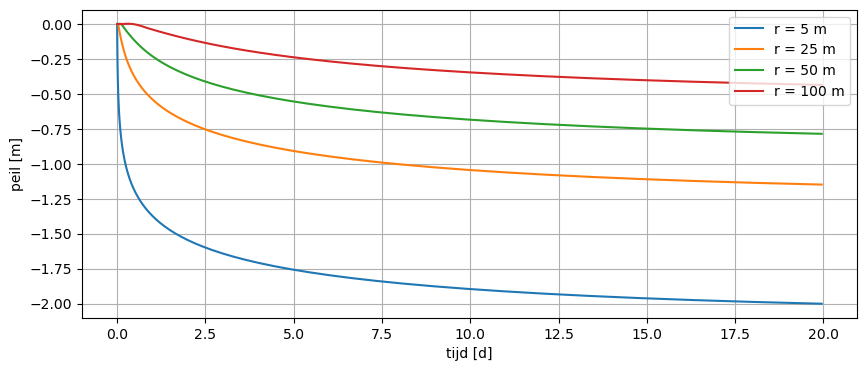

In [22]:
plt.figure(figsize=(10, 4))
for i, ri in enumerate(r):
    plt.plot(t, h[i], label=f"r = {ri} m")
plt.xlabel("tijd [d]")
plt.ylabel("peil [m]")
plt.grid()
plt.legend()

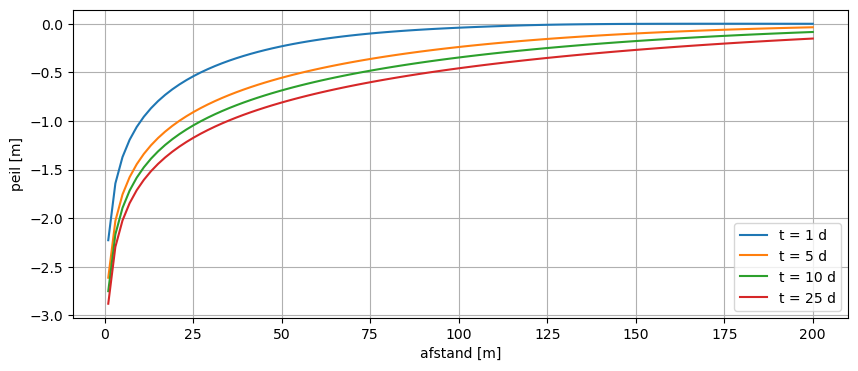

In [23]:
r = np.linspace(1, 200, 100)
t = [1, 5, 10, 25]
h = ernst_tr(r, t, T, S, Q, c, N)

plt.figure(figsize=(10, 4))
for i, ti in enumerate(t):
    plt.plot(r, h[:, i], label=f"t = {ti} d")
plt.xlabel("afstand [m]")
plt.ylabel("peil [m]")
plt.grid()
plt.legend()

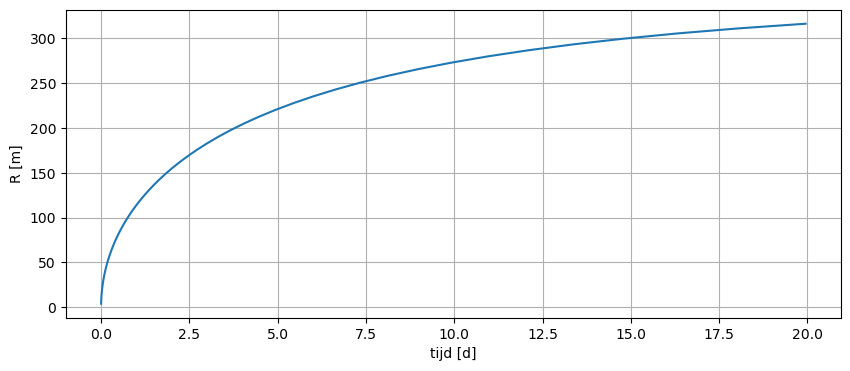

In [24]:
r = 10
t = np.logspace(-3, 1.3, 100)
R = ernst_tr(r, t, T, S, Q, c, N, return_R=True)

plt.figure(figsize=(10, 4))
plt.plot(t, R)
plt.xlabel("tijd [d]")
plt.ylabel("R [m]")
plt.grid()
